## Set up Env

In [1]:
%pip install --user torch==1.10.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install monai

In [3]:
import setuptools
import torch
import numpy as np
import h5py
from tqdm import tqdm
import time

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.metrics import compute_meandice

from scipy.ndimage import distance_transform_edt as distance
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

In [4]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    RandSpatialCropd,
    CropForegroundd,
    CenterSpatialCropd,
    NormalizeIntensityd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm_gui

## Download Data

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\ADMINI~1.WIN\AppData\Local\Temp\tmpgiwk43hx


In [6]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar"


compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
data_dir = os.path.join(root_dir, "Task02_Heart")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

Task02_Heart.tar: 100%|██████████| 435M/435M [05:32<00:00, 1.37MB/s] 


Expected md5 is None, skip md5 check for file C:\Users\ADMINI~1.WIN\AppData\Local\Temp\tmpgiwk43hx\Task02_Heart.tar.
Expected md5 is None, skip md5 check for file C:\Users\ADMINI~1.WIN\AppData\Local\Temp\tmpgiwk43hx\Task02_Heart.tar.


## Set up Dataset

In [7]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [8]:
set_determinism(seed=0)

In [9]:
image_size = (96, 96, 96)

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
     ]
 )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


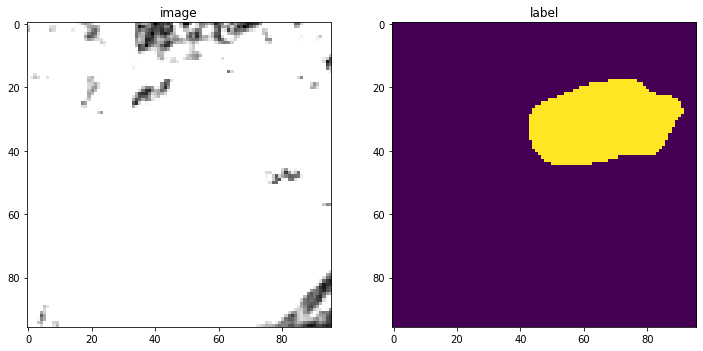

torch.Size([1, 1, 96, 96, 96])


In [11]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()
print(check_data['label'].shape)

## Set Up Loss Functions

In [12]:
def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss

## Set up Dataloader

In [13]:
#train_ds = CacheDataset(
 #   data=train_files, transform=train_transforms,
  #   cache_rate=1.0, num_workers=4)
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

#val_ds = CacheDataset(
 # data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

## Train

In [14]:
device = torch.device("cuda:0")
net = monai.networks.nets.BasicUNet().to(device)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [15]:
base_lr = 0.001
max_iterations = 20000

In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=base_lr, weight_decay=0.0001)

In [17]:
iter_num = 0
alpha = 1.0

lr_ = base_lr

In [18]:
max_epochs = 2
val_interval = 2
epoch_loss_values = []
val_epoch_loss_values = []
dice_metric_values = []
time_list_epoch = []
time_list_batch = []
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

In [19]:
for epoch_num in range(max_epochs):
    time_list_epoch.append(time.time())
    print(f"epoch {epoch_num + 1}")
    net.train()
    step = 0
    for i_batch, sampled_batch in enumerate(train_loader):
         time_list_batch.append(time.time())
        step +=1
        print(f"step {step}")
        volume_batch, label_batch = sampled_batch['image'].cuda(), sampled_batch['label'].cuda()
        outputs = net(volume_batch)
        outputs, label_batch = outputs.type(torch.Tensor), label_batch.type(torch.Tensor)

        outputs_soft = F.softmax(outputs, dim=1)
        # compute distance maps and hd loss


        loss = dice_loss(outputs_soft[:, 1, :, :, :], label_batch == 1)
        # y_pred = post_pred(outputs)
        # y = post_label(label_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch_num + 1) % val_interval == 0:
        new_loss = 0
        net.eval()
        val_step = 0
        with torch.no_grad():
            val_step +=1
            print(f"val_step {val_step}")
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].cuda(),
                    val_data["label"].cuda()
                )
                roi_size = (96,96,96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, net)
                val_outputs, val_labels = val_outputs.type(torch.Tensor), val_labels.type(torch.Tensor)
                outputs_soft = F.softmax(val_outputs, dim=1)
                val_loss= dice_loss(outputs_soft[:, 1, :, :, :], val_labels == 1)

                # val_outputs = post_pred(val_outputs)
                # val_labels = post_label(val_labels)

epoch 1
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
epoch 2
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
val_step 1


In [ ]:
time_list_epoch

In [ ]:
a = np.array(time_list_epoch)
delta_time_epoch = np.diff(a)

In [ ]:
b = np.array(time_list_batch)
delta_time_step = np.diff(b)

In [ ]:
avg_step_time = np.mean(delta_time_step)
avg_step_time # should be about ~2 seconds per step

In [ ]:
avg_epoch_time = np.mean(delta_time_epoch)
avg_epoch_time # should be about ~20 seconds per epoch

In [ ]:
avg_epoch_time